# Doom CNN Action Prediction Training

This notebook implements a custom CNN to predict player actions from Doom gameplay frames.

## Approach
- **Data Cleaning**: Filter out frames with no actions (all false)
- **Model**: Custom CNN with sigmoid outputs for multi-label classification
- **Actions**: [move_left, move_right, attack] - independent binary predictions

## Optional GPU Setup for Mac 

To use your Mac M2 GPU for faster training:

1. **Install TensorFlow with Metal support:**
   ```bash
   pip uninstall tensorflow tensorflow-macos tensorflow-metal  # Clean install
   pip install tensorflow-macos tensorflow-metal
   ```


In [ ]:
# Install required packages if needed

# For Mac M1/M2/M3 GPU acceleration (Apple Silicon):
#!pip install tensorflow-macos tensorflow-metal opencv-python numpy matplotlib scikit-learn

# For other systems (Linux/Windows/Intel Mac):
# !pip install tensorflow opencv-python numpy matplotlib scikit-learn


### General setup

In [ ]:
import json
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


### Only run below cell for Mac gpu setup

In [ ]:
# import json
# import os
# import numpy as np
# import cv2
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import matplotlib.pyplot as plt
# from pathlib import Path
# from sklearn.model_selection import train_test_split

# # Check TensorFlow and GPU setup
# print(f"TensorFlow version: {tf.__version__}")
# print(f"\n{'='*60}")
# print("GPU/Metal Configuration:")
# print(f"{'='*60}")

# # For Mac M1/M2/M3, check for Metal devices
# try:
#     # List all physical devices
#     gpus = tf.config.list_physical_devices('GPU')
#     print(f"GPU devices: {gpus}")
    
#     # Check for Metal plugin (Apple Silicon GPU)
#     if len(gpus) == 0:
#         # Try to detect Metal
#         print("\n⚠️  No GPU detected by TensorFlow")
#         print("\nTo enable M2 GPU acceleration:")
#         print("1. Install: pip install tensorflow-macos tensorflow-metal")
#         print("2. Restart your Jupyter kernel")
#         print("3. The GPU should show as 'METAL' device")
#         print("\nCurrently running on: CPU")
#     else:
#         print(f"\n✓ GPU acceleration enabled!")
#         for gpu in gpus:
#             print(f"  - {gpu}")
        
#         # Optional: Set memory growth to avoid allocating all GPU memory
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         print("\n✓ Memory growth enabled (dynamic allocation)")
    
#     # Show all available devices
#     print(f"\nAll available devices:")
#     for device in tf.config.list_logical_devices():
#         print(f"  - {device}")
        
# except Exception as e:
#     print(f"Error checking GPU: {e}")
#     print("Running on CPU")

# print(f"{'='*60}")

TensorFlow version: 2.16.2

GPU/Metal Configuration:
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✓ GPU acceleration enabled!
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

✓ Memory growth enabled (dynamic allocation)

All available devices:
  - LogicalDevice(name='/device:CPU:0', device_type='CPU')
  - LogicalDevice(name='/device:GPU:0', device_type='GPU')


2025-10-12 17:14:35.193142: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-10-12 17:14:35.193170: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-12 17:14:35.193177: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-12 17:14:35.193221: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-12 17:14:35.193230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 1. Data Loading & Cleaning

Load episode JSON files and filter out frames with no actions (all false).

**Data Cleaning Options:**
- `delete_no_action_frames=True` (default): Permanently deletes frames and images with no actions from disk
- `delete_no_action_frames=False`: Only filters data for training without deleting files


In [2]:
def load_and_filter_episode_data(data_dir="my_gameplay_data", delete_no_action_frames=True):
    """
    Load episode JSON files and filter out frames with no actions.
    Optionally deletes frames with no actions from disk and updates JSON files.
    
    Args:
        data_dir: Directory containing gameplay data
        delete_no_action_frames: If True, permanently deletes frames and images with no actions
    
    Returns:
        filtered_data: List of frame data dictionaries with at least one action=True
        total_frames: Total number of frames before filtering
    """
    episodes_dir = os.path.join(data_dir, "episodes")
    episode_files = [f for f in os.listdir(episodes_dir) if f.endswith('.json')]
    
    print(f"Found {len(episode_files)} episode files")
    if delete_no_action_frames:
        print("🗑️  Mode: DELETE frames with no actions from disk")
    else:
        print("📋 Mode: Filter only (no deletion)")
    
    all_frames = []
    filtered_frames = []
    deleted_images = 0
    deleted_entries = 0
    
    for episode_file in episode_files:
        episode_path = os.path.join(episodes_dir, episode_file)
        print(f"\nProcessing: {episode_file}")
        
        with open(episode_path, 'r') as f:
            episode_data = json.load(f)
        
        original_count = len(episode_data)
        all_frames.extend(episode_data)
        
        # Separate frames with and without actions
        frames_with_actions = []
        frames_without_actions = []
        
        for frame in episode_data:
            action = frame['action']
            if any(action):  # If any action is True
                frames_with_actions.append(frame)
                filtered_frames.append(frame)
            else:
                frames_without_actions.append(frame)
        
        # Delete frames without actions if requested
        if delete_no_action_frames and len(frames_without_actions) > 0:
            print(f"  Deleting {len(frames_without_actions)} frames with no actions...")
            
            # Delete image files
            for frame in frames_without_actions:
                frame_path = frame.get('frame_path')
                if frame_path and os.path.exists(frame_path):
                    try:
                        os.remove(frame_path)
                        deleted_images += 1
                    except Exception as e:
                        print(f"    Warning: Failed to delete {frame_path}: {e}")
            
            deleted_entries += len(frames_without_actions)
            
            # Update the JSON file with only frames that have actions
            if len(frames_with_actions) > 0:
                with open(episode_path, 'w') as f:
                    json.dump(frames_with_actions, f, indent=2)
                print(f"  ✓ Updated JSON: {len(frames_with_actions)}/{original_count} frames kept")
            else:
                print(f"  ⚠️  No frames with actions in this episode")
        elif not delete_no_action_frames:
            print(f"  {len(frames_with_actions)}/{original_count} frames have actions")
    
    print(f"\n{'=' * 60}")
    print(f"SUMMARY")
    print(f"{'=' * 60}")
    print(f"Total frames: {len(all_frames)}")
    print(f"Frames with actions: {len(filtered_frames)}")
    print(f"Frames without actions: {len(all_frames) - len(filtered_frames)}")
    
    if delete_no_action_frames:
        print(f"\n🗑️  DELETED:")
        print(f"  - {deleted_entries} JSON entries")
        print(f"  - {deleted_images} image files")
    
    if len(filtered_frames) > 0:
        # Show action distribution
        actions_array = np.array([f['action'] for f in filtered_frames])
        print(f"\nAction distribution (frames with each action):")
        print(f"  Move Left:  {int(actions_array[:, 0].sum())}")
        print(f"  Move Right: {int(actions_array[:, 1].sum())}")
        print(f"  Attack:     {int(actions_array[:, 2].sum())}")
    
    return filtered_frames, len(all_frames)

# Load the data
filtered_data, total_frames = load_and_filter_episode_data()


Found 1 episode files
🗑️  Mode: DELETE frames with no actions from disk

Processing: episode_simple_000_20251012_165702.json

SUMMARY
Total frames: 6161
Frames with actions: 6161
Frames without actions: 0

🗑️  DELETED:
  - 0 JSON entries
  - 0 image files

Action distribution (frames with each action):
  Move Left:  2444
  Move Right: 2474
  Attack:     1478


## 2. Data Preprocessing

Prepare images and actions for training. Resize frames to a smaller size for efficiency.


In [3]:
# Configuration
IMG_HEIGHT = 160
IMG_WIDTH = 120
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

print(f"Target image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")


Target image size: 160x120
Batch size: 32


In [4]:
def load_and_preprocess_image(frame_path, target_height=IMG_HEIGHT, target_width=IMG_WIDTH):
    """
    Load an image and preprocess it for the model.
    
    Args:
        frame_path: Path to the frame image
        target_height: Target height for resizing
        target_width: Target width for resizing
    
    Returns:
        Preprocessed image as numpy array normalized to [0, 1]
    """
    # Read image
    img = cv2.imread(frame_path)
    
    if img is None:
        raise ValueError(f"Failed to load image: {frame_path}")
    
    # Convert BGR to RGB (cv2 loads as BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize to target size
    img = cv2.resize(img, (target_width, target_height))
    
    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0
    
    return img

def prepare_dataset(frame_data_list):
    """
    Prepare images and labels from frame data.
    
    Args:
        frame_data_list: List of frame data dictionaries
    
    Returns:
        images: numpy array of preprocessed images
        actions: numpy array of action labels
    """
    images = []
    actions = []
    
    print(f"Loading and preprocessing {len(frame_data_list)} images...")
    
    for i, frame_data in enumerate(frame_data_list):
        if i % 100 == 0:
            print(f"Processing {i}/{len(frame_data_list)}...", end='\r')
        
        try:
            # Load and preprocess image
            img = load_and_preprocess_image(frame_data['frame_path'])
            images.append(img)
            
            # Convert boolean actions to float32
            action = [float(a) for a in frame_data['action']]
            actions.append(action)
            
        except Exception as e:
            print(f"\nWarning: Failed to load frame {frame_data['frame_path']}: {e}")
            continue
    
    print(f"\nSuccessfully loaded {len(images)} images")
    
    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    actions = np.array(actions, dtype=np.float32)
    
    return images, actions

# Only prepare dataset if we have filtered data
if len(filtered_data) > 0:
    print("Preparing dataset...")
    X, y = prepare_dataset(filtered_data)
    print(f"\nDataset shape:")
    print(f"  Images: {X.shape}")
    print(f"  Actions: {y.shape}")
else:
    print("\n⚠️  WARNING: No frames with actions found!")
    print("The current episode data has all actions = [false, false, false].")
    print("You'll need to record new gameplay with actual keyboard input.")
    X, y = np.array([]), np.array([])


Preparing dataset...
Loading and preprocessing 6161 images...
Processing 6100/6161...
Successfully loaded 6161 images

Dataset shape:
  Images: (6161, 160, 120, 3)
  Actions: (6161, 3)


In [5]:
# Split into training and validation sets
if len(X) > 0:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=VALIDATION_SPLIT, random_state=42
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    
    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    print(f"\nTensorFlow datasets created successfully!")
else:
    print("Skipping dataset split (no data available)")


Training set: 4928 samples
Validation set: 1233 samples

TensorFlow datasets created successfully!


## 3. CNN Model Architecture

Build a custom CNN with multiple convolutional layers and sigmoid outputs for multi-label classification.


In [6]:
def build_action_prediction_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_actions=3):
    """
    Build a custom CNN for action prediction.
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_actions: Number of action outputs (3: left, right, attack)
    
    Returns:
        Compiled Keras model
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Convolutional Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Convolutional Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer: 3 independent sigmoid outputs for multi-label classification
        layers.Dense(num_actions, activation='sigmoid', name='action_outputs')
    ])
    
    return model

# Build the model
model = build_action_prediction_cnn()
print("Model built successfully!")


Model built successfully!


## 4. Model Compilation

Compile the model with appropriate loss function and metrics for multi-label classification.


In [7]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Multi-label classification
    metrics=[
        'binary_accuracy',  # Overall accuracy
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("Model compiled successfully!")
print("\nOptimizer: Adam (lr=0.001)")
print("Loss: Binary Crossentropy (multi-label)")
print("Metrics: Binary Accuracy, Precision, Recall")


Model compiled successfully!

Optimizer: Adam (lr=0.001)
Loss: Binary Crossentropy (multi-label)
Metrics: Binary Accuracy, Precision, Recall


In [8]:
# Display model summary
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 120, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 7, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,879,779 (10.99 MB)

 Trainable params: 2,878,115 (10.98 MB)

 Non-trainable params: 1,664 (6.50 KB)


Total parameters: 2,879,779


## 5. Visualize Sample Data 

Visualize a few sample frames to verify preprocessing.


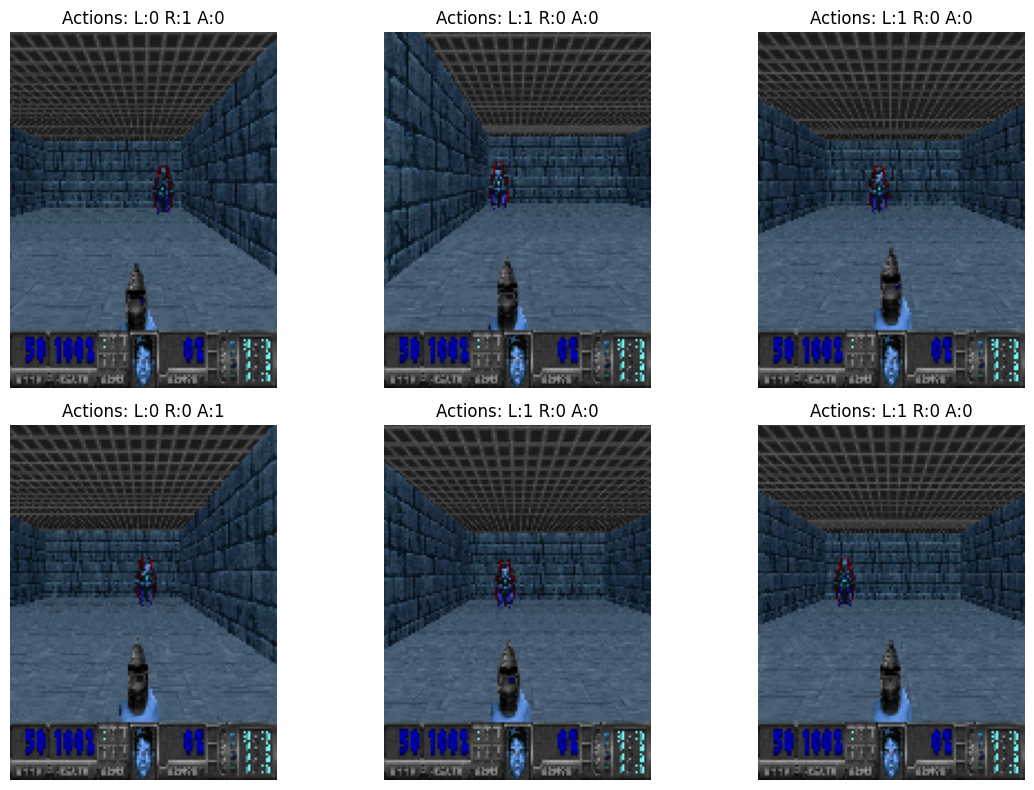

In [9]:
# Visualize a few samples if data is available
if len(X) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    # Show 6 random samples
    indices = np.random.choice(len(X_train), size=min(6, len(X_train)), replace=False)
    
    for i, idx in enumerate(indices):
        axes[i].imshow(X_train[idx])
        action = y_train[idx]
        action_str = f"L:{int(action[0])} R:{int(action[1])} A:{int(action[2])}"
        axes[i].set_title(f"Actions: {action_str}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available to visualize")


In [10]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
        keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]
)

Epoch 1/20


2025-10-12 17:15:48.628006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


154/154 ━━━━━━━━━━━━━━━━━━━━ 53s 279ms/step - binary_accuracy: 0.8762 - loss: 0.3553 - precision: 0.7817 - recall: 0.8902 - val_binary_accuracy: 0.6523 - val_loss: 1.4945 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - binary_accuracy: 0.9198 - loss: 0.2379 - precision: 0.8719 - recall: 0.9004 - val_binary_accuracy: 0.5036 - val_loss: 0.9479 - val_precision: 0.2571 - val_recall: 0.2263 - learning_rate: 0.0010
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 256ms/step - binary_accuracy: 0.9307 - loss: 0.2069 - precision: 0.8984 - recall: 0.9014 - val_binary_accuracy: 0.5204 - val_loss: 0.8539 - val_precision: 0.3242 - val_recall: 0.3499 - learning_rate: 0.0010
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 258ms/step - binary_accuracy: 0.9315 - loss: 0.1932 - precision: 0.9022 - recall: 0.8992 - val_binary_accuracy: 0.8748 - val_loss: 0.3203 - val_precision: 0.7884 - val_recall: 0.8748 - learning_rate: 0.0010